# Modeling – Using Contextual Data

## Importing Packages

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(os.path.join('data_files',
                              'congress_data_set.csv'), index_col=0)

In [3]:
df.shape

(15078, 22)

In [4]:
df.head(1)

,bill_id,num,congress,long_title,date_filed,scope,status,author,date_lastUpdate,Pass,...,Bloc,Years of Service,num_authors,delta_days,upper,mon,quarter,scope_national,majority_bloc,len_desc
0,17SBN-2235,SBN-2235,17,an act establishing the fiscal regime for the ...,5/28/19,National,"Pending Second Reading, Special Order","Drilon, Franklin M., Recto, Ralph G., Sotto II...",5/28/19,False,...,Minority,24,4,0,False,5,2,True,False,61


## Feature Selection

In [5]:
df = df[(df.status == 'Sent to the Archives') | (df['Pass'] == True)]
print(f"Data Points: {df.shape[0]:,}")

Data Points: 529


In [6]:
df.Pass.value_counts()

True     438
False     91
Name: Pass, dtype: int64

In [7]:
df.columns

Index(['bill_id', 'num', 'congress', 'long_title', 'date_filed', 'scope',
       'status', 'author', 'date_lastUpdate', 'Pass',
       'Full Name Primary Author', 'Party', 'Bloc', 'Years of Service',
       'num_authors', 'delta_days', 'upper', 'mon', 'quarter',
       'scope_national', 'majority_bloc', 'len_desc'],
      dtype='object')

In [8]:
cols_of_interest = ['bill_id', 'Party', 'Years of Service', 'num_authors',
                    'delta_days', 'mon', 'scope_national', 'majority_bloc',
                    'len_desc', 'Pass']
ndf = df[cols_of_interest]

In [9]:
ndf.shape

(529, 10)

## Data Preprocessing

### Month field

In [10]:
month_dict = {1: 'January', 2: 'February', 3: 'March',
              4: 'April', 5: 'May', 6: 'June', 7: 'July',
              8: 'August', 9: 'September', 10: 'October',
              11: 'November', 12: 'December'}

In [11]:
ndf['month'] = ndf.mon.map(lambda month: month_dict.get(month))

In [12]:
ndf.drop(['mon'], axis=1, inplace=True)

In [13]:
ndf.head()

,bill_id,Party,Years of Service,num_authors,delta_days,scope_national,majority_bloc,len_desc,Pass,month
1,17SBN-2234,Nacionalista,18,3,34,True,True,300,True,May
2,17SBN-2233,PDP_Laban,3,6,34,True,True,426,True,May
7,17SBN-2228,Nacionalista,6,3,40,True,True,201,True,May
40,17SBN-2195,Nacionalista,12,4,151,True,False,258,True,January
47,17SBN-2188,PDP_Laban,9,2,73,False,True,354,True,January


In [14]:
ndf.dtypes

bill_id             object
Party               object
Years of Service     int64
num_authors          int64
delta_days           int64
scope_national        bool
majority_bloc         bool
len_desc             int64
Pass                  bool
month               object
dtype: object

### Encode Categorical fields

In [15]:
cols_to_encode = ndf.select_dtypes(include=[object]).columns.tolist()
cols_to_encode.remove('bill_id')
cols_to_encode

['Party', 'month']

In [16]:
ndf = pd.get_dummies(ndf, columns=cols_to_encode, drop_first=True)

In [17]:
ndf.shape

(529, 32)

In [18]:
ndf.head(1)

,bill_id,Years of Service,num_authors,delta_days,scope_national,majority_bloc,len_desc,Pass,Party_Bagumbayan-VNP,Party_Independent,...,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
1,17SBN-2234,18,3,34,True,True,300,True,0,0,...,0,0,0,0,0,0,1,0,0,0


### Reorder Dataframe

In [19]:
cols_to_move = ['Pass']
cols = [col for col in ndf if col not in cols_to_move] + cols_to_move
ndf = ndf[cols]

In [20]:
ndf.to_pickle(os.path.join('data_files', 'encoded.pkl'))

## Correlation Matrix

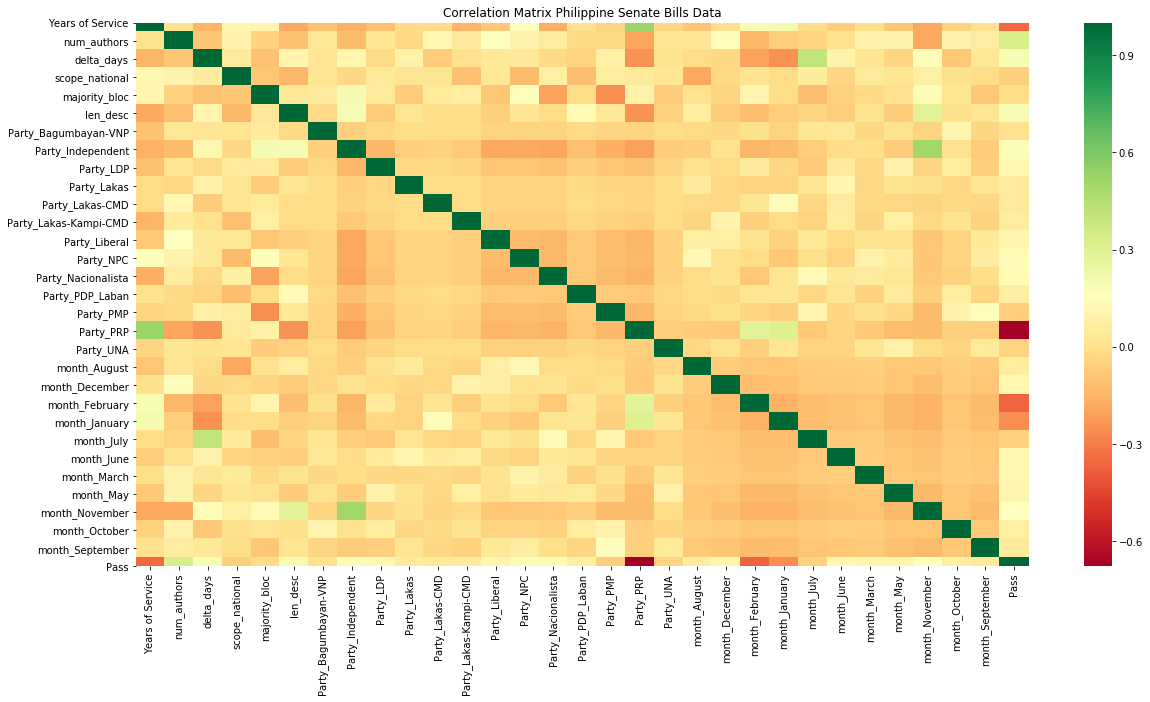

In [21]:
cor = ndf.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(cor, annot=False, cmap="RdYlGn")
plt.title('Correlation Matrix Philippine Senate Bills Data')
plt.show()

In [22]:
cor.Pass

Years of Service        -0.353261
num_authors              0.334389
delta_days               0.197407
scope_national          -0.057920
majority_bloc           -0.017514
len_desc                 0.194832
Party_Bagumbayan-VNP     0.008949
Party_Independent        0.184177
Party_LDP                0.119459
Party_Lakas              0.052783
Party_Lakas-CMD          0.044525
Party_Lakas-Kampi-CMD    0.069443
Party_Liberal            0.103794
Party_NPC                0.131441
Party_Nacionalista       0.130164
Party_PDP_Laban          0.072617
Party_PMP               -0.064774
Party_PRP               -0.676308
Party_UNA               -0.047070
month_August             0.063013
month_December           0.113387
month_February          -0.364208
month_January           -0.254779
month_July              -0.047712
month_June               0.119459
month_March              0.111762
month_May                0.107994
month_November           0.164771
month_October            0.073637
month_Septembe

### Feature Selection

In [23]:
colsOfInterest = list(cor[(cor.Pass > 0.3) |
                          (cor.Pass < -0.3)]['Pass'].index)
print(len(colsOfInterest))
colsOfInterest

5


['Years of Service', 'num_authors', 'Party_PRP', 'month_February', 'Pass']

In [24]:
ndf = ndf[colsOfInterest]
ndf.head(3)

,Years of Service,num_authors,Party_PRP,month_February,Pass
1,18,3,0,0,True
2,3,6,0,0,True
7,6,3,0,0,True


## Train-Test Split

### Xy Variable Selection

In [25]:
X = ndf.drop(['Pass'], axis=1)
print(X.shape)

(529, 4)


In [26]:
y = ndf['Pass']
y.shape

(529,)

### Standardization

In [27]:
scaler = StandardScaler()

In [28]:
X = scaler.fit_transform(X)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=43)

In [30]:
print(f"Our new train set has {X_train.shape[0]} data points;",
      f"{np.sum(y_train)} of which are actual positives.")

Our new train set has 396 data points; 331 of which are actual positives.


## SVC

In [31]:
svc = SVC(gamma='auto', kernel='linear', random_state=42)

In [32]:
svc.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [33]:
predicted = svc.predict(X_test)

In [34]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

       False       1.00      0.81      0.89        26
        True       0.96      1.00      0.98       107

    accuracy                           0.96       133
   macro avg       0.98      0.90      0.94       133
weighted avg       0.96      0.96      0.96       133



## RF

In [35]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15,
                                  random_state=42)

In [36]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [37]:
predicted = rf_model.predict(X_test)

In [38]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

       False       0.92      0.88      0.90        26
        True       0.97      0.98      0.98       107

    accuracy                           0.96       133
   macro avg       0.95      0.93      0.94       133
weighted avg       0.96      0.96      0.96       133



## k-Fold Cross Validation

#### Using K-Neighbors Classifier

In [39]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print(scores)

[0.90566038 0.88679245 0.96226415 0.98113208 0.98113208 1.
 1.         0.94339623 0.88679245 0.88461538]


In [40]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

0.943178519593614


In [41]:
# search for an optimal value of K for KNN
k_range = list(range(1, 31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.9299346879535559, 0.9223149492017416, 0.9356313497822931, 0.933744557329463, 0.943178519593614, 0.9412917271407839, 0.9280478955007256, 0.9205007256894049, 0.9223875181422351, 0.9223875181422351, 0.9261611030478955, 0.9242380261248186, 0.9223875181422352, 0.911066763425254, 0.9223875181422352, 0.9166908563134978, 0.9242743105950652, 0.9205007256894049, 0.9242743105950652, 0.9242743105950652, 0.9261611030478955, 0.9223875181422352, 0.9223875181422352, 0.9205007256894049, 0.9205007256894049, 0.9148040638606677, 0.9148040638606677, 0.9148040638606677, 0.9148040638606677, 0.9148040638606677]


Text(0, 0.5, 'Cross-Validated Accuracy')

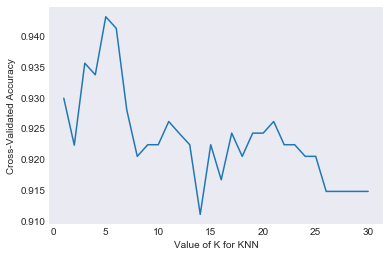

In [42]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.style.use('seaborn-dark')

plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

#### Using Logistic Regression

In [43]:
# Best k for knn is 8. How about Logistic Regression?
# 10-fold cross-validation with logistic regression
logreg = LogisticRegression()
print(cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean())

0.9243105950653121


#### Using Decision Tree Classifier

In [44]:
tree_model = DecisionTreeClassifier(random_state=42)
print(cross_val_score(tree_model, X, y, cv=10, scoring='accuracy').mean())

0.941255442670537


#### Using Random Forest Classifier

In [45]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15,
                                  random_state=42)
print(cross_val_score(rf_model, X, y, cv=10, scoring='accuracy').mean())

0.9450290275761974


In [46]:
# search for an optimal value of K for KNN
n_range = list(range(5, 15))
rf_scores = []
for n in n_range:
    rf_model = RandomForestClassifier(n_estimators=200, max_depth=n,
                                      random_state=42)
    scores = cross_val_score(rf_model, X, y, cv=10, scoring='accuracy')
    rf_scores.append(scores.mean())
print(rf_scores)

[0.9356313497822933, 0.9337808417997095, 0.9393686502177069, 0.9450290275761974, 0.9450290275761974, 0.9450290275761974, 0.9450290275761974, 0.9450290275761974, 0.9450290275761974, 0.9450290275761974]


Text(0, 0.5, 'Cross-Validated Accuracy')

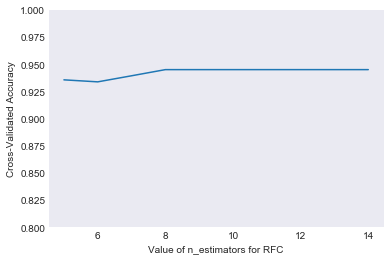

In [47]:
# plot the value of K for rf (x-axis) vs the cross-validated accuracy (y-axis)
plt.style.use('seaborn-dark')

plt.plot(n_range, rf_scores)
plt.ylim(0.8, 1)
plt.xlabel('Value of n_estimators for RFC')
plt.ylabel('Cross-Validated Accuracy')